In [1]:
import sys
sys.path.append('../') 

from models.decision_tree import DecisionTreeModel
from models.logistic_regression import LogisticRegressionModel
from models.rnn import RNNModel
from models.random_forest import RandomForestModel
import numpy as np
import pandas as pd
import joblib
import pickle
import os
import csv
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import os
from pathlib import Path
cwd = Path.cwd()
root = cwd.parent


In [2]:
data = pd.read_csv(root / 'data' / 'lgd_dataset_2024-05-02T08_37_10.703874Z.csv')

In [3]:
export_path = root / "param_optimalization/{curr_time}/"
import_path = root / "model_files/pd_pre_behav_model"
random_state = 42
visualization_weight = 1

In [4]:
import_path

WindowsPath('f:/Desktop/git/credit-risk-models/model_files/pd_pre_behav_model')

In [5]:
X_train = pd.read_csv(import_path / "X_train.csv")
X_test = pd.read_csv(import_path / "X_test.csv")
X_train_woe = pd.read_csv(import_path / "X_train_woe.csv")
X_test_woe = pd.read_csv(import_path / "X_test_woe.csv")
y_train = pd.read_csv(import_path / "y_train.csv")
y_test = pd.read_csv(import_path / "y_test.csv")
val = pd.read_csv(import_path / "val.csv")
bins = joblib.load(import_path / "bins.pkl")

with open(import_path /"columns_to_keep.csv", mode="r") as file:
            reader = csv.reader(file)
            columns_to_keep = next(reader)

with open(
            import_path /"train_columns_with_dummies.csv", mode="r"
        ) as file:
            reader = csv.reader(file)
            train_columns_with_dummies = next(reader)

categorical_columns = X_train.select_dtypes(include=["object"]).columns
X_train_model = pd.get_dummies(
    X_train, columns=categorical_columns, dtype=bool
)
X_test_model = pd.get_dummies(
    X_test, columns=categorical_columns, dtype=bool
)
missing_cols = set(train_columns_with_dummies) - set(
    X_train_model.columns
)
for col in missing_cols:
    X_train_model[col] = False

missing_cols = set(train_columns_with_dummies) - set(
    X_test_model.columns
)
for col in missing_cols:
    X_test_model[col] = False

X_train_model = X_train_model[train_columns_with_dummies]
X_test_model = X_test_model[train_columns_with_dummies]

# Good example for raw data evaluation
X_val = val[columns_to_keep]
y_val = val.loc[:, "bad"]
X_val_model = pd.get_dummies(
    X_val, columns=categorical_columns, dtype=bool
)
missing_cols = set(train_columns_with_dummies) - set(
    X_val_model.columns
)
for col in missing_cols:
    X_val_model[col] = False
X_val_model = X_val_model[train_columns_with_dummies]

y_train_model = np.ravel(y_train)
y_test_model = np.ravel(y_test)
y_val_model = np.ravel(y_val)

In [6]:
export_path = str(export_path)
import_path = str(import_path)

In [7]:
os.makedirs(export_path, exist_ok=True)

In [8]:
decision_tree = DecisionTreeModel(
            param_grid={
                "max_depth": [None, 3, 5, 10],
                "criterion": ["gini", "entropy", "log_loss"],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
            },
            output_path=export_path,
            random_state=random_state,
            visualization_weight=visualization_weight,
            export_path=export_path,
        )

In [9]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train_model, y_train_model)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

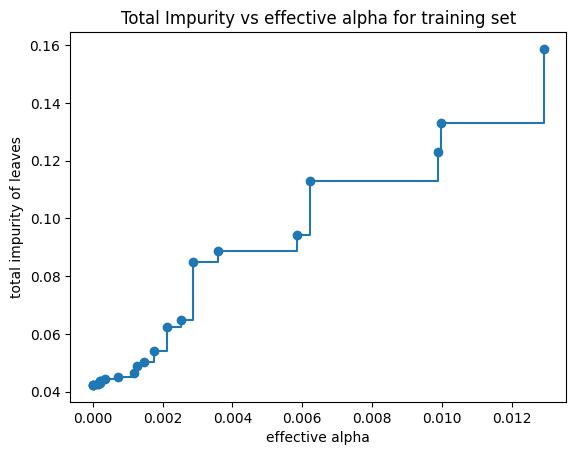

In [11]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [14]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_model, y_train_model)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.048405737096208545


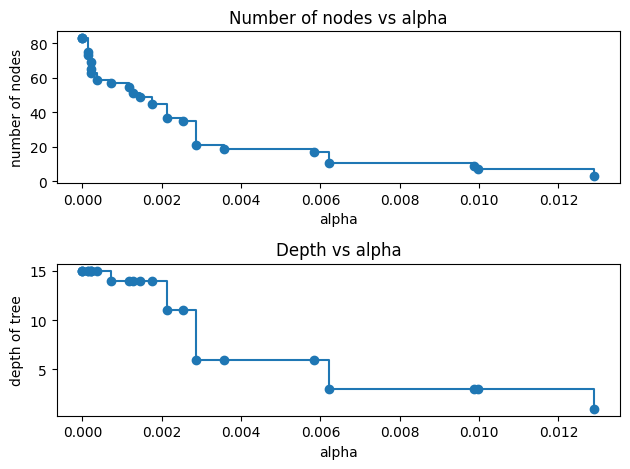

In [15]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

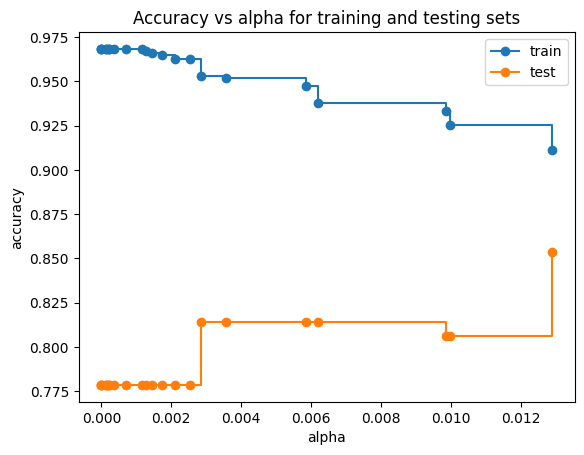

In [17]:
train_scores = [clf.score(X_train_model, y_train_model) for clf in clfs]
test_scores = [clf.score(X_test_model, y_test_model) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [24]:
ccp_alphas = np.linspace(0, 0.5, 25)
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_model, y_train_model)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.5


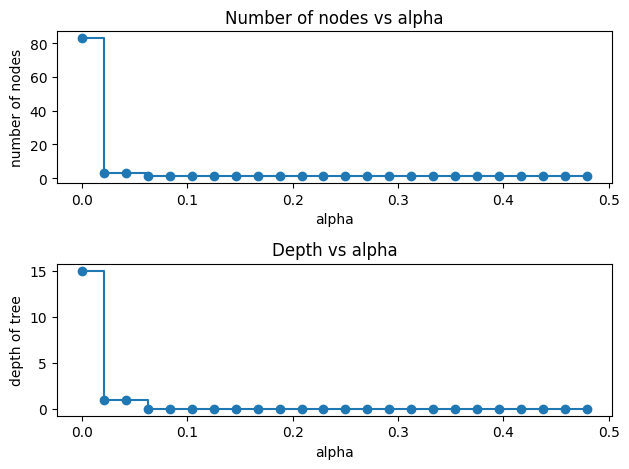

In [25]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

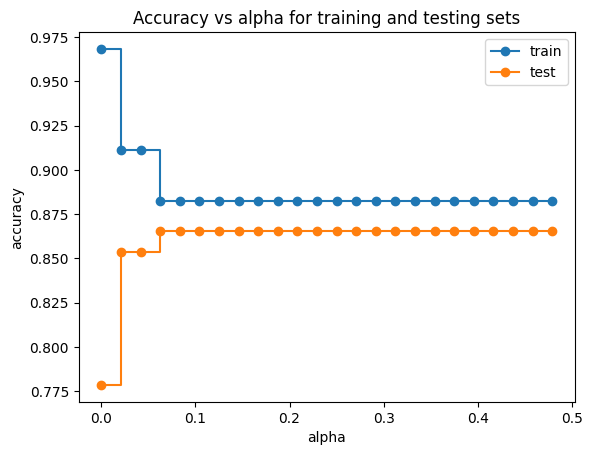

In [26]:
train_scores = [clf.score(X_train_model, y_train_model) for clf in clfs]
test_scores = [clf.score(X_test_model, y_test_model) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

X